In [76]:
#NORMALIZACJA ZMIENNYCH
import pandas as pd
import numpy as np
data=pd.read_csv('laloos.csv',sep=';',decimal=',')

npdata=np.array(data.iloc[:,1:],dtype='float64')
npdata
avg=npdata.mean(axis=0)
std=npdata.std(axis=0)
npdata.shape[1]

for i in range(npdata.shape[1]):
    npdata[:,i]=(npdata[:,i]-avg[i])/std[i]




array([[-0.72190546, -0.77159383, -1.70829637, ...,  2.55189643,
        -1.78749485, -2.02538729],
       [-0.78480529, -0.85255781, -1.73964448, ...,  2.55189643,
        -1.78749485, -2.02538729],
       [-0.81202556, -0.79392269, -1.74370379, ...,  2.55189643,
        -1.78749485, -2.02538729],
       ...,
       [ 0.61076355,  0.67194345,  0.20386628, ..., -2.21251382,
         1.34187187, -0.15444931],
       [ 0.35551268,  0.50718743,  0.17486161, ..., -2.21251382,
         1.34187187, -0.15444931],
       [ 0.35496789,  0.31819978,  0.23499699, ..., -2.01119931,
         3.18819871,  2.64040729]])

acp.csv


C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000499
std        0.014618
min       -0.076000
25%       -0.004000
50%        0.000000
75%        0.005000
max        0.074000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.012344    154
 0                      0.000000    156
 1                      0.013761    155
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean      -0.002331
std        0.026367
min       -0.148000
25%       -0.012000
50%        0.000000
75%        0.004000
max        0.131000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.024286    175
 0                      0.000000    156
 1                      0.023627    134
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean      -0.000963
std        0.028203
min       -0.179000
25%       -0.008000
50%        0.000000
75%        0.008000
max        0.145000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.026722    151
 0                      0.000000    149
 1                      0.021739    165
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean      -0.000092
std        0.013347
min       -0.052000
25%       -0.004000
50%        0.000000
75%        0.003000
max        0.070000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.012392    153
 0                      0.000000    155
 1                      0.011803    157
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000310
std        0.018002
min       -0.069000
25%       -0.005000
50%        0.000000
75%        0.005000
max        0.087000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.015395    162
 0                      0.000000    151
 1                      0.017355    152
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.002095
std        0.037981
min       -0.147000
25%       -0.011000
50%        0.000000
75%        0.015000
max        0.272000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.030814    156
 0                      0.000000    150
 1                      0.036358    159
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean      -0.000185
std        0.022638
min       -0.094000
25%       -0.009000
50%        0.000000
75%        0.009000
max        0.092000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.020030    167
 0                      0.000000    149
 1                      0.021872    149
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000935
std        0.018279
min       -0.086000
25%       -0.004000
50%        0.000000
75%        0.007000
max        0.071000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.016020    150
 0                      0.000000    153
 1                      0.017519    162
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek nie sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.001456
std        0.027173
min       -0.157000
25%       -0.005000
50%        0.000000
75%        0.011000
max        0.121000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.024579    140
 0                      0.000000    153
 1                      0.023942    172
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000370
std        0.014392
min       -0.068000
25%       -0.005000
50%        0.000000
75%        0.006000
max        0.056000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.013154    156
 0                      0.000000    149
 1                      0.013900    160
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek nie sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])
C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.001381
std        0.021674
min       -0.157000
25%       -0.004000
50%        0.000000
75%        0.009000
max        0.158000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.018007    136
 0                      0.000000    157
 1                      0.017971    172
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000647
std        0.024350
min       -0.093000
25%       -0.007000
50%        0.000000
75%        0.006000
max        0.146000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.018812    170
 0                      0.000000    152
 1                      0.024469    143
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000398
std        0.017969
min       -0.063000
25%       -0.005000
50%        0.000000
75%        0.005000
max        0.165000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.014175    160
 0                      0.000000    152
 1                      0.016033    153
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000705
std        0.018140
min       -0.080000
25%       -0.006000
50%        0.000000
75%        0.008000
max        0.104000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.017068    147
 0                      0.000000    153
 1                      0.017194    165
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek nie sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000682
std        0.020631
min       -0.184000
25%       -0.006000
50%        0.000000
75%        0.008000
max        0.125000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.016960    150
 0                      0.000000    151
 1                      0.017445    164
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.000239
std        0.014504
min       -0.070000
25%       -0.004000
50%        0.000000
75%        0.004000
max        0.075000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.013783    143
 0                      0.000000    155
 1                      0.012467    167
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek nie sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
------------------------------------------------

C:\Users\dom\AppData\Local\Temp\ipykernel_4812\2139211822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


count    465.000000
mean       0.001032
std        0.020646
min       -0.148000
25%       -0.006000
50%        0.000000
75%        0.008000
max        0.108000
Name: Stopy procentowe, dtype: float64
                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.017457    151
 0                      0.000000    156
 1                      0.019722    158
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
----------------------------------------------------

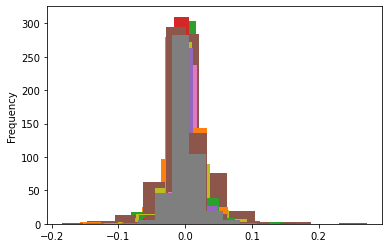

In [3]:
#Analiza gieldowa

import pandas as pd
import numpy as np
import matplotlib as mpl
import datetime
from os import listdir
from os.path import isfile, join
from datetime import timedelta
import scipy.stats
#Wczytaj dane
def ActionAnalysis(path,since_date):
    data=pd.read_csv(path,sep=',')
    data1=data[['Data','Najwyzszy','Zamkniecie']]
    data1['Data']=pd.to_datetime(data1['Data'])
    stopy=[0]
    dnitygodnia=[]
    miesiac=[]
    koniecmiesiaca=[]
    
    #UZUPEŁNIJ DANE O NIENOTOWANY WEEKEND
    ds=data1["Data"].iloc[0]
    dk=data1["Data"].iloc[-1]
    listofdates=pd.date_range(ds,dk-timedelta(days=1),freq='d').tolist()
    
    datafull=pd.DataFrame({'Data': listofdates})
    datafull = pd.merge(datafull, data1, how="left", on=["Data", "Data"])

    for i in range(len(datafull)):
        if pd.isnull(datafull.iloc[i,1]):
            datafull.iloc[i,1]=datafull.iloc[i-1,1]
            datafull.iloc[i,2]=datafull.iloc[i-1,2]

    #OKRESL DZIEN TYGODNIA
    for i in range(len(datafull)):
        dnitygodnia.append(datafull.iloc[i,0].weekday())
        dnitygodnia[i]+=1
        miesiac.append(datafull.iloc[i,0].month)
        
    #OKRESL CZY TO DANE NA KONIEC MIESIACA 
    for i in range(len(datafull)-1):
        if miesiac[i]!=miesiac[i+1]:
            koniecmiesiaca.append(1)
        else:
            koniecmiesiaca.append(0)
        stopy.append(round(np.log(datafull.iloc[i+1,2])-np.log(datafull.iloc[i,2]),3))
    koniecmiesiaca.append(0)
    
    #Dodaj nowe kolumny
    datafull['Stopy procentowe']=stopy
    datafull['Dzien tygodnia']=dnitygodnia
    datafull['Ostatni dzien miesiaca']=koniecmiesiaca
    
    #Znak stopy
    datafull['Znak stopy procentowej']=-1
    for i in range(len(datafull)):
        if datafull.iloc[i,3]>0:
            datafull.iloc[i,6]=1
        elif datafull.iloc[i,3]==0:
            datafull.iloc[i,6]=0
    datafull=datafull[datafull['Data']>=since_date]
    
    #Oblicz stopy miesieczne
    danemiesieczne=datafull[datafull['Ostatni dzien miesiaca']==1]
    for i in range(len(danemiesieczne)-1):
        danemiesieczne.iloc[i+1,3]=(round(np.log(danemiesieczne.iloc[i+1,2])-np.log(danemiesieczne.iloc[i,2]),3))

    #Oblicz statystyki dla skumulowanych stóp procentowych
    print(datafull['Stopy procentowe'].describe())
    #datafull['Stopy procentowe'].plot.hist(bins=10)

    
    
    dataX=datafull[['Stopy procentowe','Znak stopy procentowej']].groupby(['Znak stopy procentowej']).agg(Srednia=('Stopy procentowe','mean'),Ilosc=('Znak stopy procentowej','count'))
    print(dataX)
    print(80*'-')
    
    
    #Testy statystyczne - test roznic srednich dla danych dni tygodnia
    zlicz_dni=np.array(datafull.groupby(['Dzien tygodnia']).count().iloc[:5,0])
    danednitygodnia=datafull.groupby(['Dzien tygodnia']).mean().iloc[:5,2]
    danednitygodnia1=datafull.groupby(['Dzien tygodnia']).var().iloc[:5,2]
    stopywdniach=np.array(danednitygodnia)
    odchyleniawdniach=np.array(danednitygodnia1)
    slownikdni={1:'poniedzialek',2: 'wtorek',3:'sroda',4:'czwartek',5:'piatek'}
    for i in range(len(stopywdniach)):
        for j in range(len(stopywdniach)):
            if i<j:
                statystykatestowasrednie=(stopywdniach[i]-stopywdniach[j])/np.sqrt(odchyleniawdniach[i]/zlicz_dni[i]+odchyleniawdniach[j]/zlicz_dni[j])
                statystykakrytycznasrednie=scipy.stats.norm.ppf(0.975)
                if np.abs(statystykatestowasrednie)>statystykakrytycznasrednie:
                    print(f'Srednie dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} nie sa rowne')
                else:
                    print(f'Srednie dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} sa rowne')
    print(80*'-')
    
    #Testy statystyczne - test wariancji dla danych dni tygodnia
    for i in range(len(stopywdniach)):
        for j in range(len(stopywdniach)):
            if i<j:
                if odchyleniawdniach[i]>odchyleniawdniach[j]:
                    statystykatestowawariancja=odchyleniawdniach[i]/odchyleniawdniach[j]
                    statystykakrytycznawariancja=scipy.stats.f.ppf(1-0.05,dfn=zlicz_dni[i],dfd=zlicz_dni[j])
                else:
                    statystykatestowawariancja=odchyleniawdniach[j]/odchyleniawdniach[i]
                    statystykakrytycznawariancja=scipy.stats.f.ppf(1-0.05,dfn=zlicz_dni[j],dfd=zlicz_dni[i])
                if np.abs(statystykatestowawariancja)>statystykakrytycznawariancja:
                    print(f'Wariancje dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} nie sa rowne')
                else:
                    print(f'Wariancje dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} sa rowne')
    print(80*'-')           


    
    
    
    #Wyswietlanie informacji     
    print("Srednia w kolejnych dniach tygodnia")
    print(datafull[['Dzien tygodnia','Stopy procentowe']].groupby(['Dzien tygodnia']).agg(Srednia=('Stopy procentowe','mean'),Ilosc=('Stopy procentowe','count'),Wariancja=('Stopy procentowe','var')))
    
    
    print(80*'-')
    print("DANE MIESIECZNE:")
    print(danemiesieczne[['Data','Zamkniecie','Stopy procentowe']])
    print("Srednia stopa miesieczna:",danemiesieczne['Stopy procentowe'].mean())
    
    
    
onlyfiles = [f for f in listdir("C:/Users/dom/Gielda") if isfile(join("C:/Users/dom/Gielda", f))]
datestart=datetime.datetime(2021,1,1)
for i in range(len(onlyfiles)):
    print(onlyfiles[i])
    ActionAnalysis("C:/Users/dom/Gielda/"+str(onlyfiles[i]),datestart)



    

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import requests
spolki=['acp','ale','ccc','cdr','cps','dnp','jsw','kgh','lpp','lts','mbk','opl','pco','peo','pge',
        'pgn','pkn','pko','pzu','spl']
links=[]
for i in spolki:
    a='https://stooq.pl/q/d/l/?s='+i+'&i=d'
    links.append(a)
for index,element in enumerate(links):
    urllib.request.urlretrieve(element,spolki[index]+'.csv')


https://stooq.pl/q/d/l/?s=acp&i=d
https://stooq.pl/q/d/l/?s=ale&i=d
https://stooq.pl/q/d/l/?s=ccc&i=d
https://stooq.pl/q/d/l/?s=cdr&i=d
https://stooq.pl/q/d/l/?s=cps&i=d
https://stooq.pl/q/d/l/?s=dnp&i=d
https://stooq.pl/q/d/l/?s=jsw&i=d
https://stooq.pl/q/d/l/?s=kgh&i=d
https://stooq.pl/q/d/l/?s=lpp&i=d
https://stooq.pl/q/d/l/?s=lts&i=d
https://stooq.pl/q/d/l/?s=mbk&i=d
https://stooq.pl/q/d/l/?s=opl&i=d
https://stooq.pl/q/d/l/?s=pco&i=d
https://stooq.pl/q/d/l/?s=peo&i=d
https://stooq.pl/q/d/l/?s=pge&i=d
https://stooq.pl/q/d/l/?s=pgn&i=d
https://stooq.pl/q/d/l/?s=pkn&i=d
https://stooq.pl/q/d/l/?s=pko&i=d
https://stooq.pl/q/d/l/?s=pzu&i=d
https://stooq.pl/q/d/l/?s=spl&i=d
